# Energy forecasting: aggregated to a jurisdiction area

Purpose:
The purpose of this work is to predict energy consumption for a residential area.  
In the recent past, I have been curious to analyze patterns in energy consumption and eventually develop models to perform short term energy/load forecasting. Electric demand or energy consumption forecasting is nothing new to electric industry, almost every energy company uses some kind of forecasting model. Predicting the demand is essential for electric utility operations and planning in order to provide reliable electric power to customers. With the integration of Distribution Energy Resources (DERs) and emphasis on demand response management programs, the complexity in forecasting has grown many folds. This is my first attempt at it in understanding time series analysis while building a model with low test error. 

About data: 
Electric consumption (watt-hour) data for years between 2013 - 2018 is analyzed. Here, I have 15 minute interval meter readings for a small area with their geographical information. 
I will use Mean Absolute Percentage Error (MAPE) for comparing accuracies.

What else I can infer from the data:
1. The first and foremost to understand is that it is a time series data. The dependency of time requires special attention. Energy consumption patterns vary with time of day, day of week, weather patterns, holiday, size of customer, customer behavior, etc.
2. A jurisdiction area will have different types of customers - industrial, residential, commercial, farms, etc.
2. Missing data and recording errors.

For privacy and other legal concerns that might arise, I cannot provide data files. 


In [1]:
#Imports
from pymongo import MongoClient
import pandas as pd
import numpy as np

import glob
import datetime
import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn_pandas import DataFrameMapper


/home/sravan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Here I will be connecting to my mongoDB to read the required meter data using MongoClient. 
Note: Considering residential meters only. This information is provided in meter profile. 

In [2]:
GroupId = "FDR_14442"
DBModelName = "AGADEMO-model"
DBMeasurementsName = "AGADEMO-measurements"

In [3]:
#Create mongo client
client = MongoClient('localhost', 27019)
#Read meter profile
#Set database and collection
db=client[DBModelName]
coll=db['model.e.meter.profile']
#Query residential meters.
docsProf = coll.find({"rateCode":"PMRS_R","groupId":GroupId})
listMeterId = []
d = {'meterId':listMeterId}
for dc in docsProf:
    listMeterId.append(dc['meterId'])
dfMeters = pd.DataFrame(d)
dfMeters.head(), dfMeters.shape

(                              meterId
 0  776428360310_21351300_NXA112132261
 1  776428700240_21351220_1ND350444587
 2  776428700240_21351230_NXA112132238
 3  776428700240_21351250_1ND351364785
 4  776428700240_21351255_NYA111197195, (425, 1))

We got list of residential meters. Now let us run the query on meter usage database.  

In [4]:
#Read meter interval data
#Set database and collection 
db=client[DBMeasurementsName]
coll=db['measurements.meter.daily.bag']
#Query consumption data
docsReads = coll.find({"groupId":GroupId})
#Transform json documents into dataframe with consumption and timestamp.
readDate = []
meterUsage = []
meterId = []
d = {'meterId':meterId, 'DataDate':readDate, 'Usage':meterUsage}
for doc in docsReads:
    intvlData = doc['intervalData']
    for data in intvlData:
        meterId.append(doc['meterId'])
        readDate.append(data[9])
        meterUsage.append(data[0])
df = pd.DataFrame(d)

In [5]:
df.head() , df.shape

(        DataDate        Usage                             meterId
 0  1357088400000  1431.294069  777428010690_20136117_KZD353381298
 1  1357092000000  1456.469362  777428010690_20136117_KZD353381298
 2  1357095600000  1466.303461  777428010690_20136117_KZD353381298
 3  1357099200000  1493.996283  777428010690_20136117_KZD353381298
 4  1357102800000  1523.734597  777428010690_20136117_KZD353381298,
 (8532024, 3))

Here we have 21 million readings. But this is for all meters in the area. Lets extract data only for meters in dfMeters dataframe. 

In [6]:
dfUsage = pd.merge(df, dfMeters, on='meterId', how='inner')


In [7]:
dfUsage.head()

,DataDate,Usage,meterId
0,1357088400000,1185.945002,777429430560_21300410_1ND350452599
1,1357092000000,1141.532082,777429430560_21300410_1ND350452599
2,1357095600000,1145.133130,777429430560_21300410_1ND350452599
3,1357099200000,1188.345701,777429430560_21300410_1ND350452599
4,1357102800000,1189.546050,777429430560_21300410_1ND350452599


We have raw readings which need to be preprocessed. Timestamp can be extracted to individual time components. 

In [8]:
#convert timestamp in milliseconds to datetime
def tsmsToDate(ts):
    return datetime.datetime.fromtimestamp(ts/1000)

In [9]:
#Extract time and date features from consumption data
dfUsage['Date'] = dfUsage['DataDate'].apply(tsmsToDate)
dtcol = dfUsage['Date'].dt
dfUsage['year'] = dtcol.year
dfUsage['month'] = dtcol.month
dfUsage['daymonth'] = dtcol.day
dfUsage['hour'] = dtcol.hour
dfUsage['dayinweek'] = dtcol.weekday

In [10]:
dfUsage.head()

,DataDate,Usage,meterId,Date,year,month,daymonth,hour,dayinweek
0,1357088400000,1185.945002,777429430560_21300410_1ND350452599,2013-01-01 20:00:00,2013,1,1,20,1
1,1357092000000,1141.532082,777429430560_21300410_1ND350452599,2013-01-01 21:00:00,2013,1,1,21,1
2,1357095600000,1145.133130,777429430560_21300410_1ND350452599,2013-01-01 22:00:00,2013,1,1,22,1
3,1357099200000,1188.345701,777429430560_21300410_1ND350452599,2013-01-01 23:00:00,2013,1,1,23,1
4,1357102800000,1189.546050,777429430560_21300410_1ND350452599,2013-01-02 00:00:00,2013,1,2,0,2


Aggregate user consumption to a day. The dataframe dfUsageDaily holds aggregated daily user consumption readings for all meters under consideration. 

In [11]:
dfUsageDaily = dfUsage.groupby(['year','month','daymonth'])['Usage'].sum().reset_index()

In [12]:
dfUsageDaily.shape

(827, 4)

In [13]:
#Filter outliers around mean
def rejectOutliers(data, s =2.):
    flags = []
    stdev = np.std(data)
    mean = np.mean(data)
    slow = mean - s * stdev
    sup = mean + s * stdev
    for d in data:
        if d < slow or d > sup:
            flags.append(False)
        else:
            flags.append(True)
    return flags

In [14]:
#Converting watthour to kwh
dfUsageDaily['Usage'] = dfUsageDaily['Usage']/1000
#dfUsageDaily = dfUsageDaily[rejectOutliers(dfUsageDaily['Usage'])]


In [15]:
dfUsageDaily.head()

,year,month,daymonth,Usage
0,2013,1,1,4.660956
1,2013,1,2,41.910111
2,2013,1,3,79.960422
3,2013,1,4,76.447949
4,2013,1,5,77.976908


In [16]:
dfUsageDaily.year.unique(), dfUsageDaily.month.unique(), dfUsageDaily.daymonth.unique()

(array([2013, 2014, 2015, 2018]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]))

## Visualization
Considering 2013 and 2014 data. 

In [17]:
dfUsageDailyY = pd.DataFrame()
#dfUsageDaily2013 = dfUsageDaily[dfUsageDaily['year']==2013]
#dfUsageDailyY = dfUsageDaily2013[dfUsageDaily2013['month']>=6]  ##Bad data for Jan-May 2013
dfUsageDailyY = dfUsageDailyY.append(dfUsageDaily[dfUsageDaily['year']==2014])
#dfUsageDailyY = dfUsageDailyY[dfUsageDailyY['month']==8]

dfUsageDailyY = dfUsageDailyY.append(dfUsageDaily[dfUsageDaily['year']==2015])

In [18]:
dfUsageDailyY.count()

year        457
month       457
daymonth    457
Usage       457
dtype: int64

In [19]:
#convert timestamp in milliseconds to datetime
def paramToDate(y,m,d):
    dt= datetime.datetime(year=y, month=m, day=d)
    return dt

To visualize as time series, I moved the data into panda series.

In [20]:
y = pd.Series()
y = list(map(lambda x : paramToDate(x.year,x.month,x.daymonth), dfUsageDailyY.itertuples()))
series = pd.Series( dfUsageDailyY['Usage'].values, y)
series[0:5]

2014-01-01    11822.307025
2014-01-02    12942.309043
2014-01-03    14432.091790
2014-01-04    13826.123779
2014-01-05    13338.632715
dtype: float64

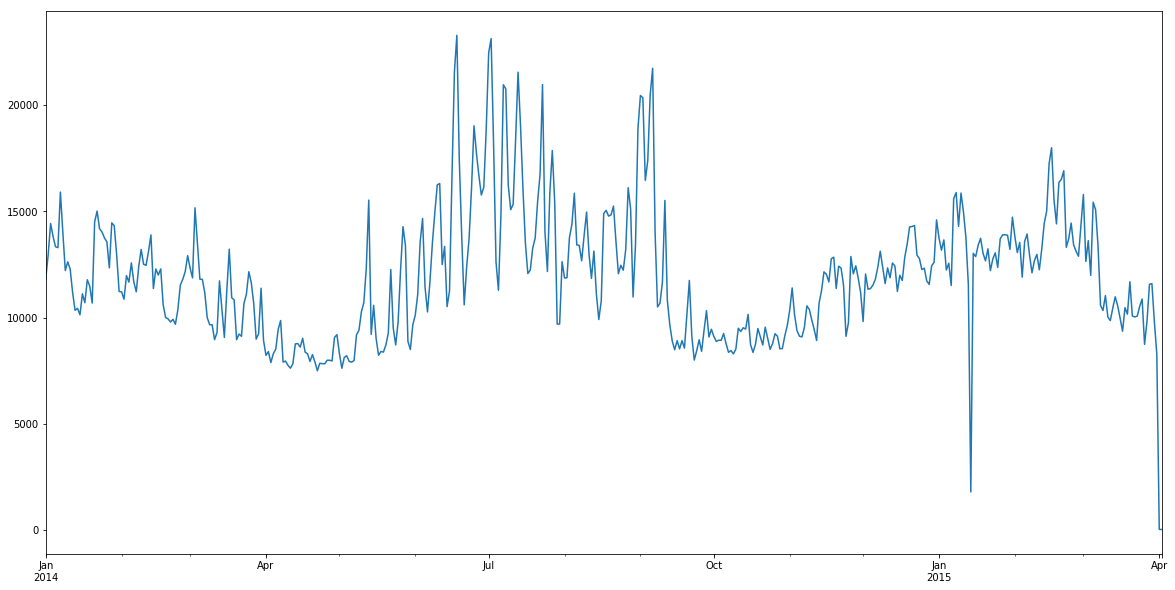

In [21]:
plt.figure(figsize=(20,10))
series.plot()

Observations:
1. Cyclical patterns across the year - probably seasonal variations.
2. Small cycles within month - probably daily/weekly variations.
3. Can be a lot of other things including white noise.

### Is the series stationary ?
Lets plot auto-correlation and partial correlation plots.

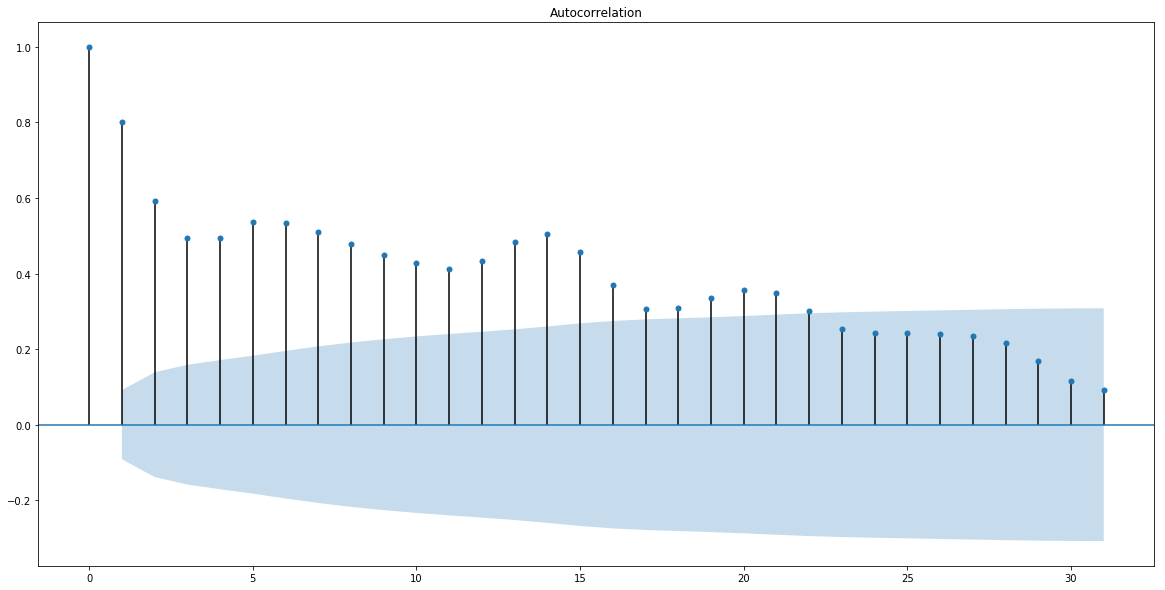

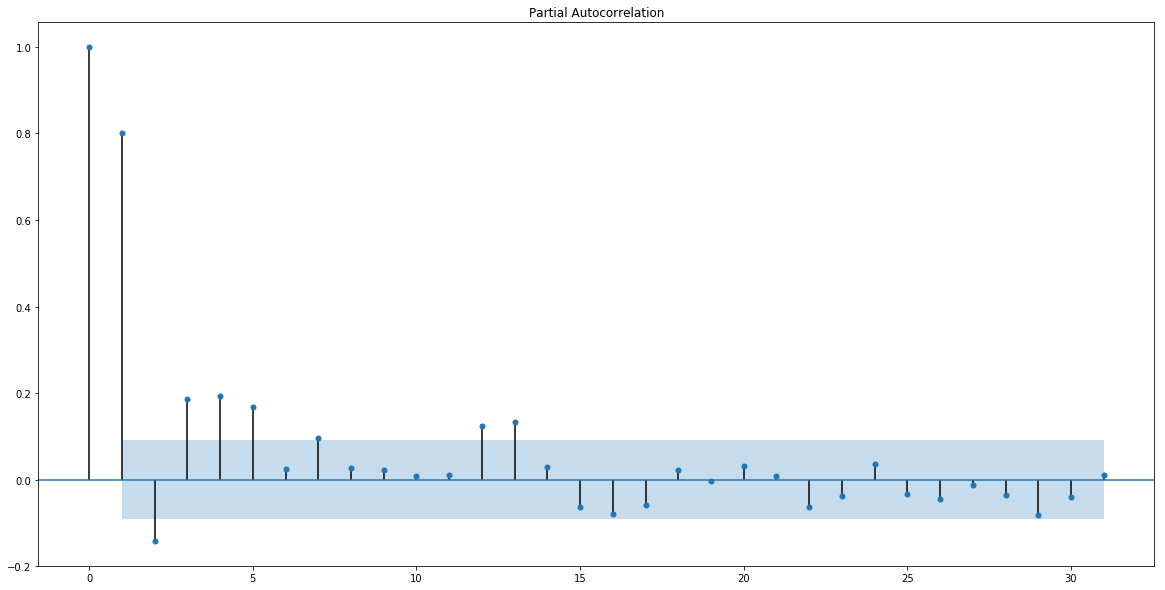

In [22]:
plt.rc("figure", figsize=(20,10))
fig = plot_acf(dfUsageDailyY['Usage'], lags=31)
fig1=plot_pacf(dfUsageDailyY['Usage'], lags=31)

Does not look stationary. Lot of points outside the critical boundary. 

#### Augmented Dickey-Fuller test

In [23]:
result = adfuller(dfUsageDailyY.Usage)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.638200
p-value: 0.463201
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


ADF statistic value is greater than 1%. This indicates of non-stationarity. Lets make the series stationary. Here I will experiment with different things such as differencing, applying log or both.

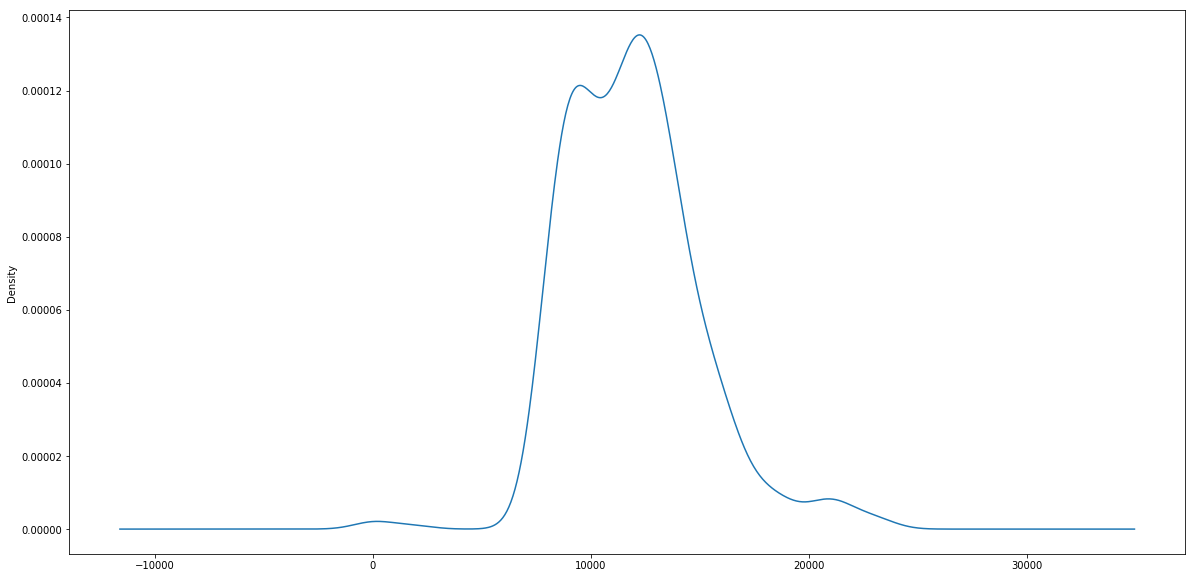

In [24]:
dfUsageDailyY.Usage.plot(kind='kde')

Perform difference of series

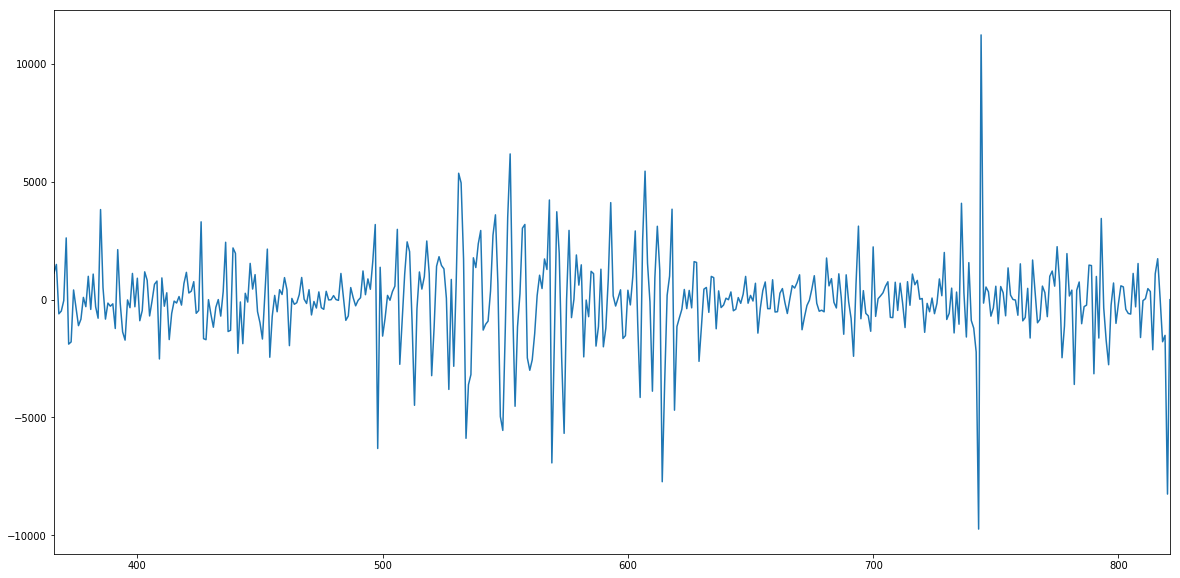

In [25]:
diff1Usage = dfUsageDailyY['Usage'].diff()
diff1Usage = diff1Usage.dropna()
plt.figure(figsize=(20,10))

diff1Usage.plot()

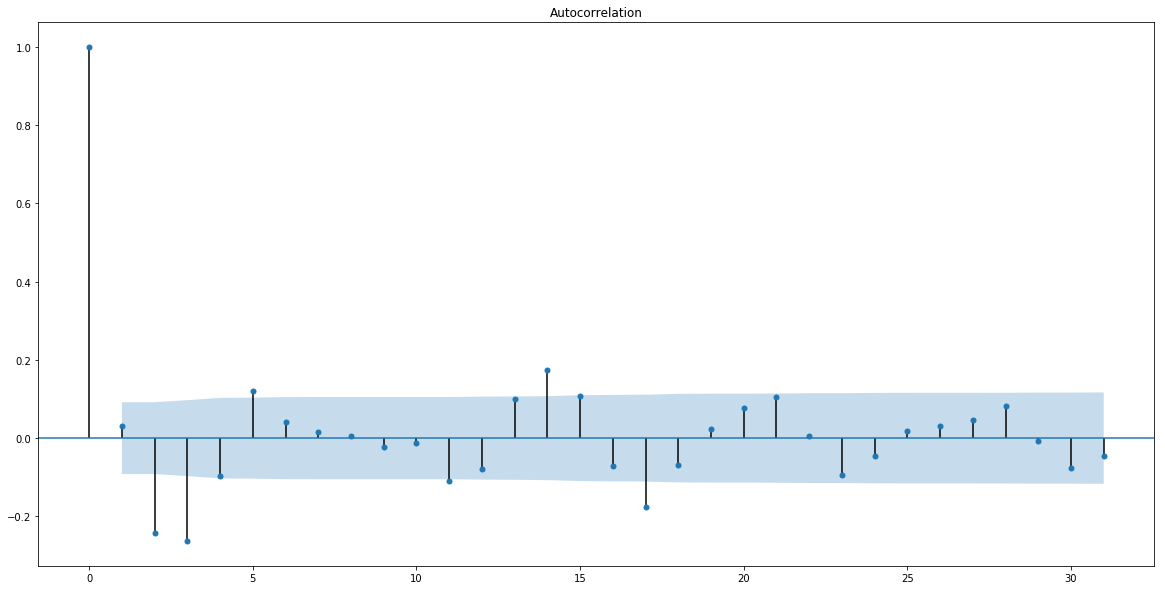

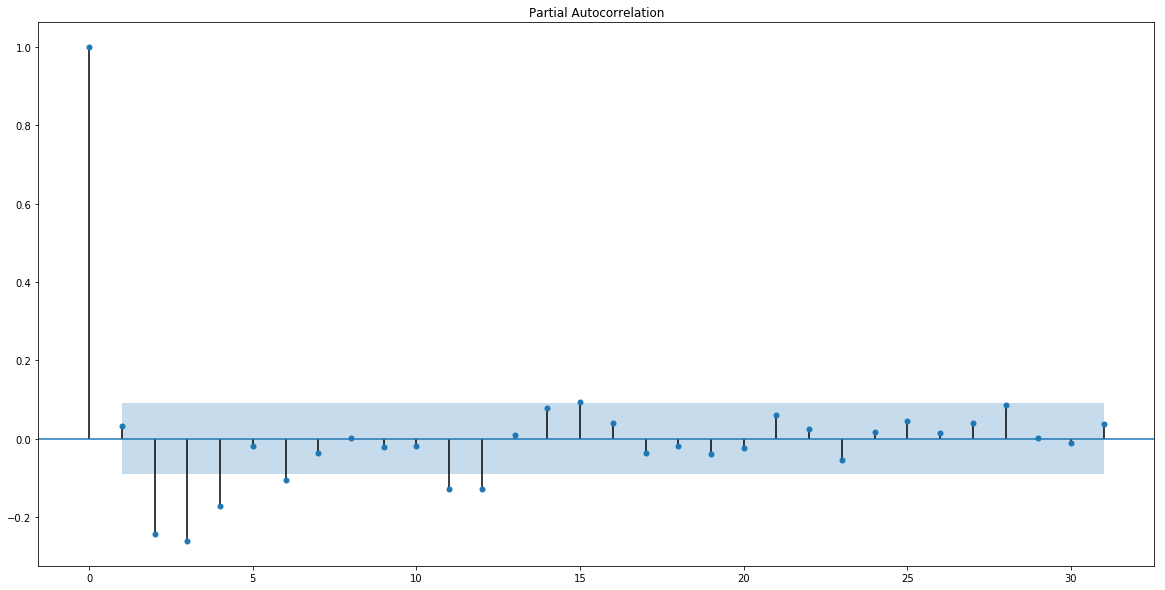

In [26]:
fig=plot_acf(diff1Usage, lags=31)
fig1=plot_pacf(diff1Usage, lags=31)

In [27]:
result = adfuller(diff1Usage)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.739731
p-value: 0.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


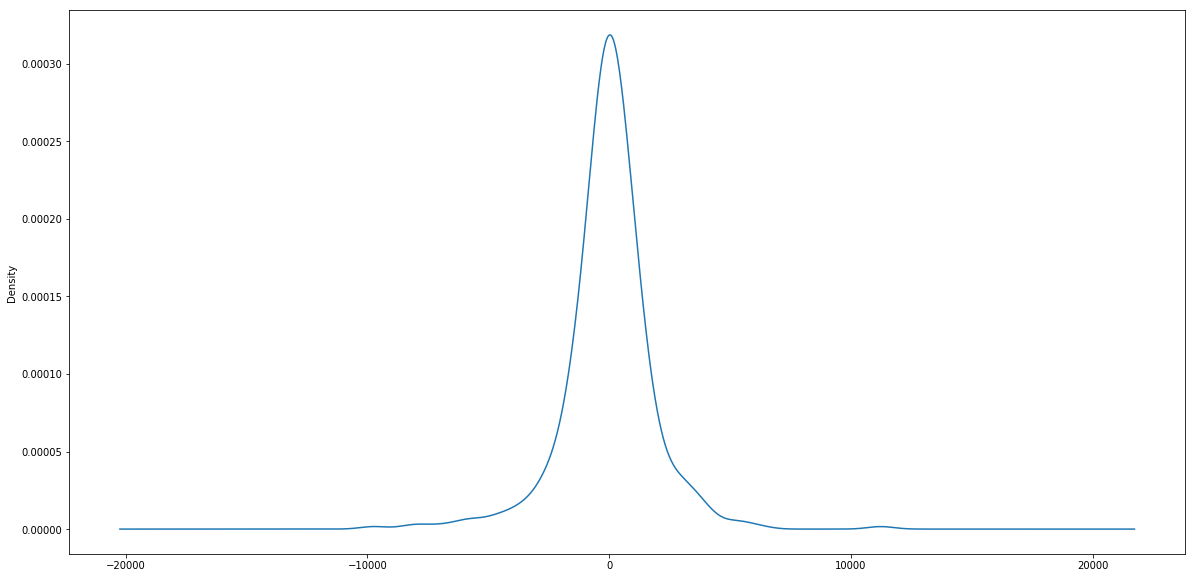

In [28]:
diff1Usage.plot(kind='kde')

Looks lot better. Will try some more things.

ADF Statistic: -1.756394
p-value: 0.402316
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


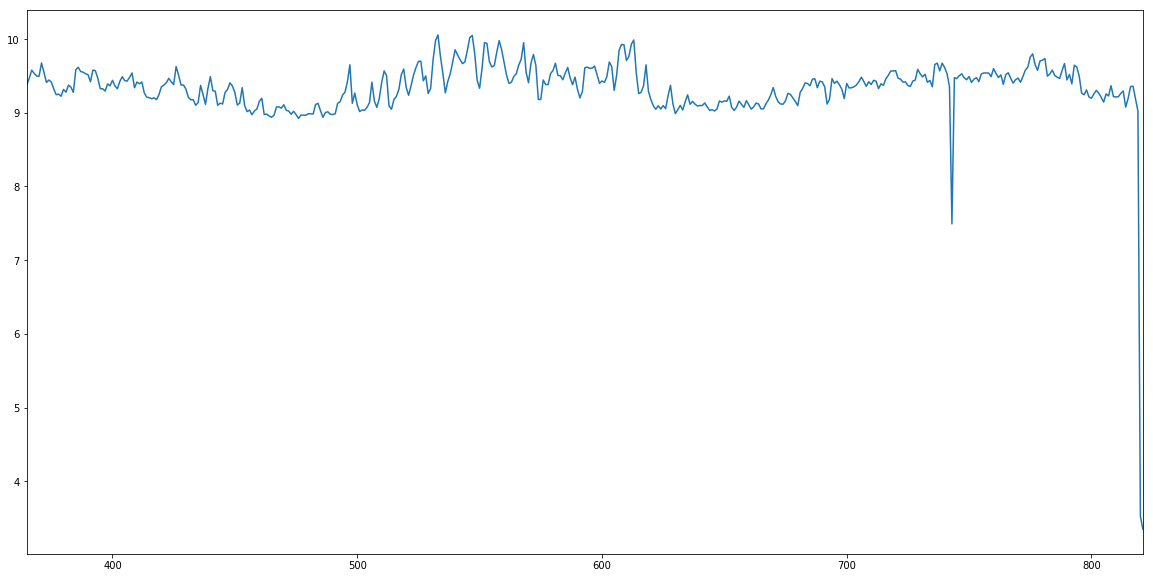

In [29]:
diffLUsage = log(dfUsageDailyY.Usage)
diffLUsage = diffLUsage.dropna()
plt.figure(figsize=(20,10))
diffLUsage.plot()

from statsmodels.tsa.stattools import adfuller
result = adfuller(diffLUsage)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.214302
p-value: 0.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


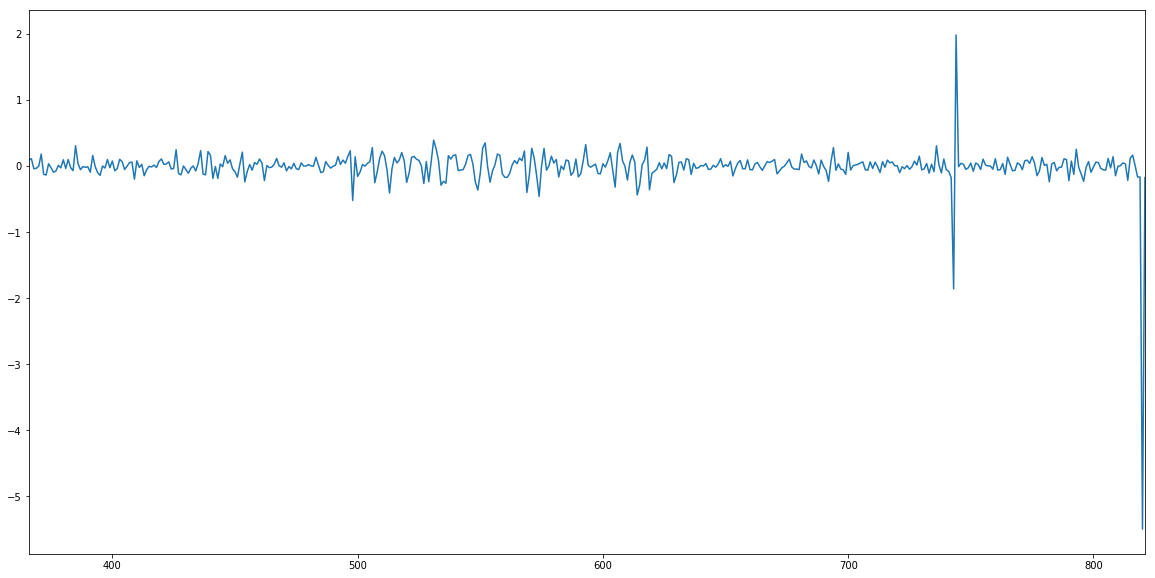

In [30]:
diffLUsage = log(dfUsageDailyY.Usage)
diffLDUsage = diffLUsage.diff()
diffLDUsage = diffLDUsage.dropna()

plt.figure(figsize=(20,10))
diffLDUsage.plot()

result = adfuller(diffLDUsage)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

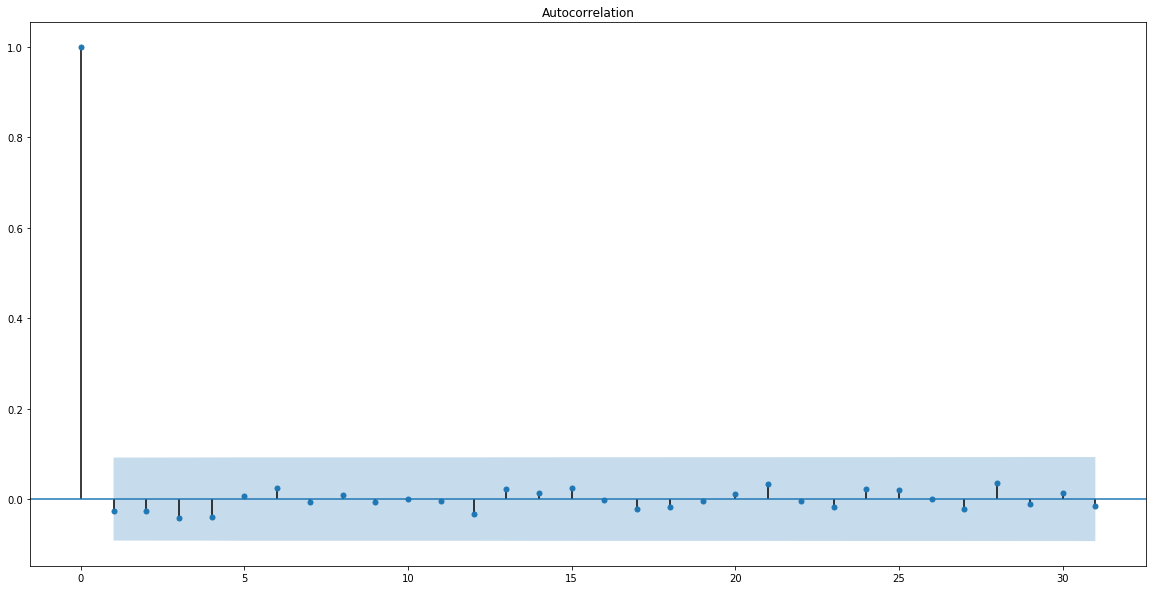

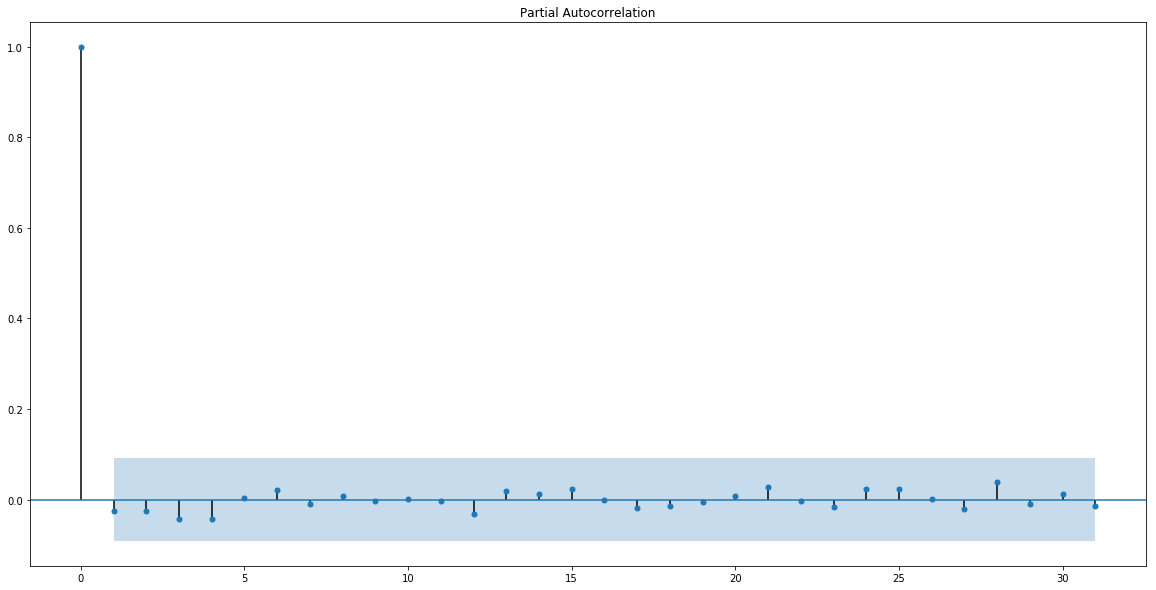

In [31]:
fig = plot_acf(diffLDUsage, lags=31)
fig1=plot_pacf(diffLDUsage, lags=31)

Difference of log values looks great. ACF and PCF shows no signs of dependence on past values.

### Time series decomposition

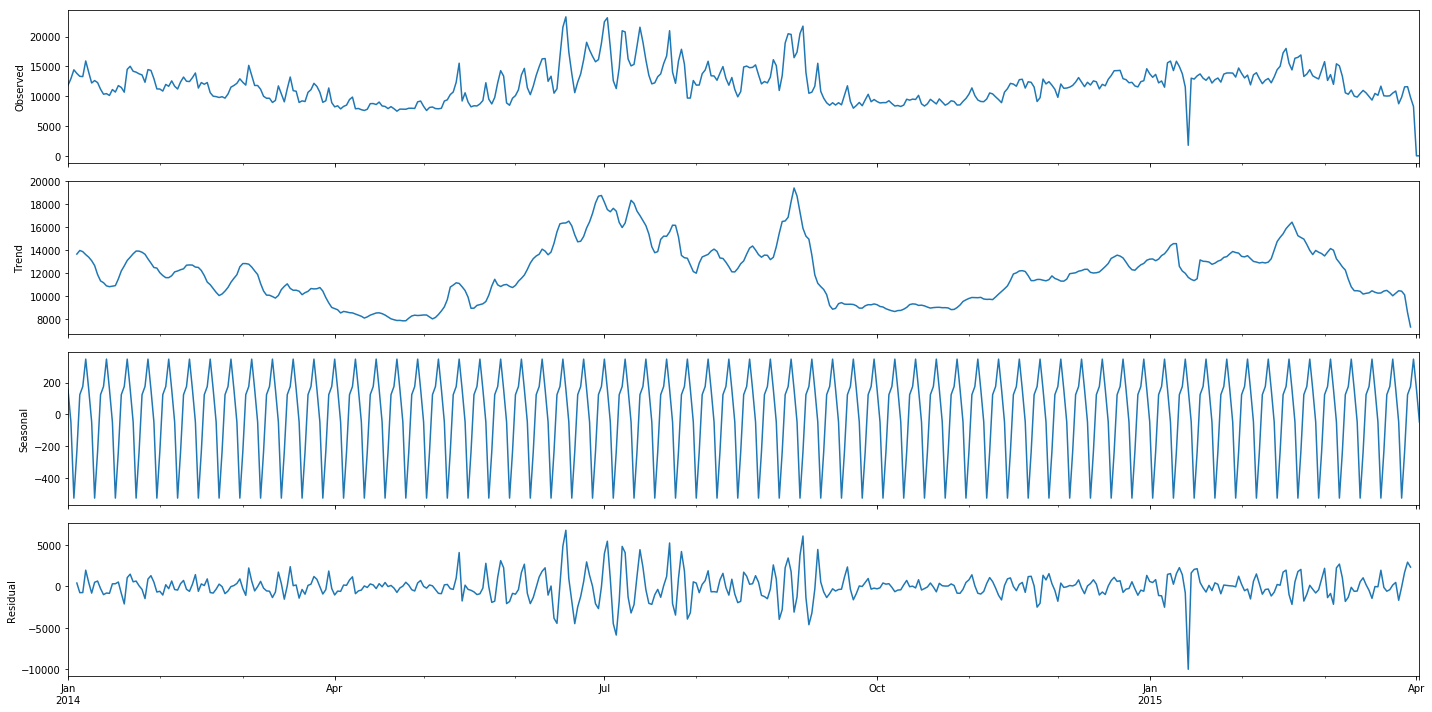

In [32]:
decomposition = seasonal_decompose(series, model='additive')
fig = decomposition.plot()

Here we see that the series exhibits cyclic trend. Also, we see high frequency seasonal variations and residual. 
We need to train a model that accounts for seasonal variations. 
I am interested in building regression based models. I will be experimenting with different independent variables that might have an affect on system load. 
Some of the obvious variables will be weather parameters and time. There can be many other variables such as customers house sqft, customer behaviour, renewebles, demand response plan, etc. 
For my analysis, I am dealing with weather and time parameters. 

### Weather data

In [33]:
#Courtesy: https://www.noaa.gov/
#Read weather data
#read weather hourly data from csv
path="/home/sravan/Dolphin/STLF/V1/"
dfWeather = pd.read_csv(path+"weather_washington_reagan_airport.csv")

In [34]:
#Sample data:
#Date	Temperature		DAILYHeatingDegreeDays	DAILYCoolingDegreeDays	DAILYAverageRelativeHumidity	HourlyRelativeHumidity	HourlyWindSpeed	HourlyVisibility	DailySunrise	DailySunset
#2013-01-11 01:00	44		17	0		51	0	9.94	726	1706
#2013-01-11 01:52	43					56	0	10	726	1706
#2013-01-11 02:52	41					62	0	10	726	1706
#2013-01-11 03:52	40					70	0	10	726	1706



In [35]:
dfWeather.describe()

,Unnamed: 2,DAILYHeatingDegreeDays,DAILYCoolingDegreeDays,DAILYAverageRelativeHumidity,HourlyRelativeHumidity,HourlyWindSpeed,DailySunrise,DailySunset
count,0.0,2909.000000,2909.000000,678.000000,30760.000000,30747.00000,31545.000000,31545.000000
mean,NaN,12.146442,4.308697,59.132743,63.343466,8.40882,593.055603,1797.811222
std,NaN,13.664652,6.257287,13.512402,18.769669,5.18879,98.110778,96.911128
min,NaN,0.000000,0.000000,25.000000,12.000000,0.00000,442.000000,1646.000000
25%,NaN,0.000000,0.000000,49.000000,48.000000,5.00000,513.000000,1719.000000
50%,NaN,7.000000,0.000000,59.000000,65.000000,8.00000,611.000000,1807.000000
75%,NaN,23.000000,9.000000,69.000000,81.000000,11.00000,702.000000,1905.000000
max,NaN,53.000000,23.000000,95.000000,100.000000,46.00000,727.000000,1937.000000


It looks like it needs lot of cleaning and aggregation. 

In [36]:
#set date format and convert string to datetime
fmt="%Y-%m-%d %H:%M"
def strToDate(str):
    return datetime.datetime.strptime(str,fmt)

In [37]:
#Extract time and date features from weather data
#The weather data doesnt align to a time grid. Also HDD and CDD are provided for the entire day. 
#HDD and CDD can be computed from temperature. So, these can be dependent values that wont help regression models. We will keep them for now.
dfw = pd.DataFrame()
dfw2 = pd.DataFrame()
dfw['Date'] = dfWeather['Date'].apply(strToDate)
dfw['Temperature'] = pd.to_numeric(dfWeather['Temperature'],errors='coerce')
dfw2['Hdd'] = pd.to_numeric(dfWeather['DAILYHeatingDegreeDays'],errors='coerce')
dfw2['Cdd'] = pd.to_numeric(dfWeather['DAILYCoolingDegreeDays'],errors='coerce')
dfw = dfw.dropna()
dtcol = dfw['Date'].dt
dfw['year'] = dtcol.year
dfw['month'] = dtcol.month
dfw['daymonth'] = dtcol.day
dfw['hour'] = dtcol.hour
dfw['dayinweek'] = dtcol.weekday
dfw2['year'] = dtcol.year
dfw2['month'] = dtcol.month
dfw2['daymonth'] = dtcol.day
dfw2['hour'] = dtcol.hour
dfw2grpHdd = dfw2.groupby(['year','month','daymonth'])['Hdd'].mean().reset_index()
dfw2grpCdd = dfw2.groupby(['year','month','daymonth'])['Cdd'].mean().reset_index()
dfw2daily = pd.merge(dfw2grpHdd, dfw2grpCdd,  how='left', on=['year','month','daymonth'])
dfwdaily = dfw.groupby(['year','month','daymonth','dayinweek'])['Temperature'].mean().reset_index()
dfwdaily = pd.merge(dfwdaily, dfw2daily,  how='left', on=['year','month','daymonth'])
dfwDaily = dfwdaily.dropna()

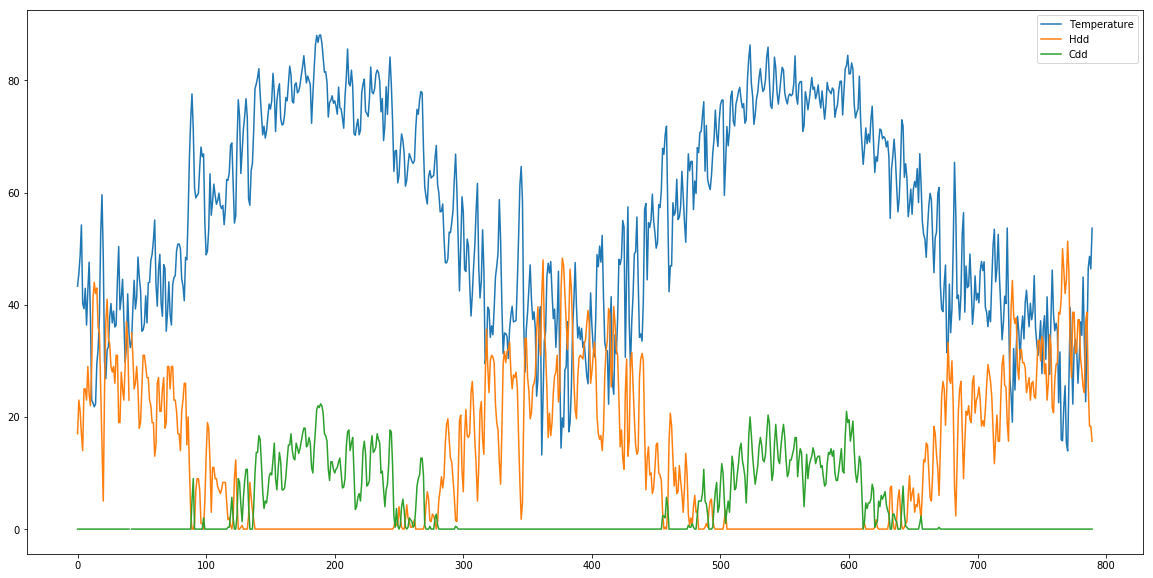

In [38]:
plt.figure(figsize=(20,10))
plt.plot(dfwdaily['Temperature'])
plt.plot(dfwdaily['Hdd'])
plt.plot(dfwdaily['Cdd'])
plt.legend()

Data looks reasonable for daily temperatures for period January 2013 - March 2015.

In [39]:
#Merge usage and weather data so that we have data for same day.
df_full = pd.merge(dfUsageDailyY, dfwDaily,  how='inner', on=['year','month','daymonth'])
df_full.head()

,year,month,daymonth,Usage,dayinweek,Temperature,Hdd,Cdd
0,2014,1,1,11822.307025,2,38.750000,26.000000,0.0
1,2014,1,2,12942.309043,3,35.688525,27.333333,0.0
2,2014,1,3,14432.091790,4,23.707317,35.000000,0.0
3,2014,1,4,13826.123779,5,26.575758,39.666667,0.0
4,2014,1,5,13338.632715,6,37.813559,34.000000,0.0


In [40]:
df_full.describe(), df_full.tail()

(              Usage   dayinweek  Temperature         Hdd         Cdd
 count    435.000000  435.000000   435.000000  435.000000  435.000000
 mean   12062.440695    2.997701    54.267470   14.469540    3.568966
 std     3010.500168    2.000575    18.679471   14.286785    5.592219
 min     1794.711893    0.000000    13.218750    0.000000    0.000000
 25%     9589.219620    1.000000    37.885653    0.000000    0.000000
 50%    11908.010252    3.000000    54.738095   11.666667    0.000000
 75%    13643.373022    5.000000    72.078235   26.500000    6.666667
 max    23291.055200    6.000000    86.324324   51.333333   21.000000,
      year month daymonth         Usage  dayinweek  Temperature        Hdd  Cdd
 430  2015     3        7  13343.798136          5    33.375000  38.666667  0.0
 431  2015     3        8  10577.047283          6    46.531250  25.666667  0.0
 432  2015     3        9  10336.432475          0    48.625000  18.333333  0.0
 433  2015     3       10  11039.225510          

In [41]:
#Create more features
#create another feature that says if it is a weekend or not.
df_full['weekend'] = np.array(df_full['dayinweek']>=5,dtype=int) 
df['prevWkUsage'] = df['Usage'].shift(7*24)
#df['prevDayUsage'] = df['Usage'].shift(24)
#Diffs for 1 lag
df['diffL1Usage'] = df['Usage'].shift(1) - df['Usage'].shift(2)
print("Columns:", df_full.columns)

Columns: Index(['year', 'month', 'daymonth', 'Usage', 'dayinweek', 'Temperature', 'Hdd',
       'Cdd', 'weekend'],
      dtype='object')


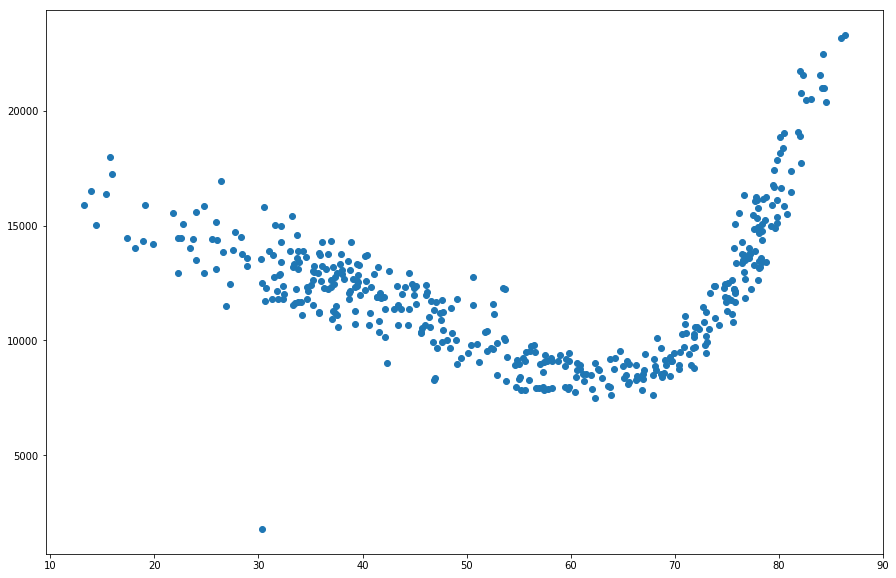

In [42]:
plt.figure(figsize=(15,10))
plt.scatter(df_full['Temperature'], df_full['Usage']);

The plot above is Energy consumption vs Temperature. The energy usage is at its lowest when the temperature is around 65F, but it is linear with high slope when the temperature gets hotter. 

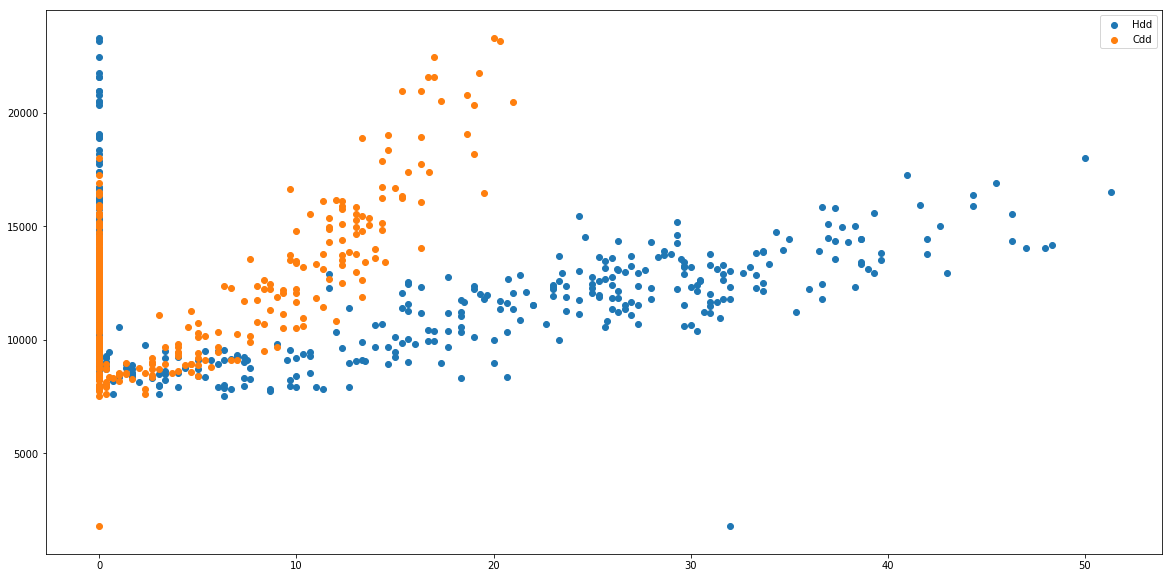

In [43]:
plt.scatter(df_full['Hdd'],df_full['Usage']);
plt.scatter(df_full['Cdd'], df_full['Usage']);
plt.legend(('Hdd', 'Cdd'))

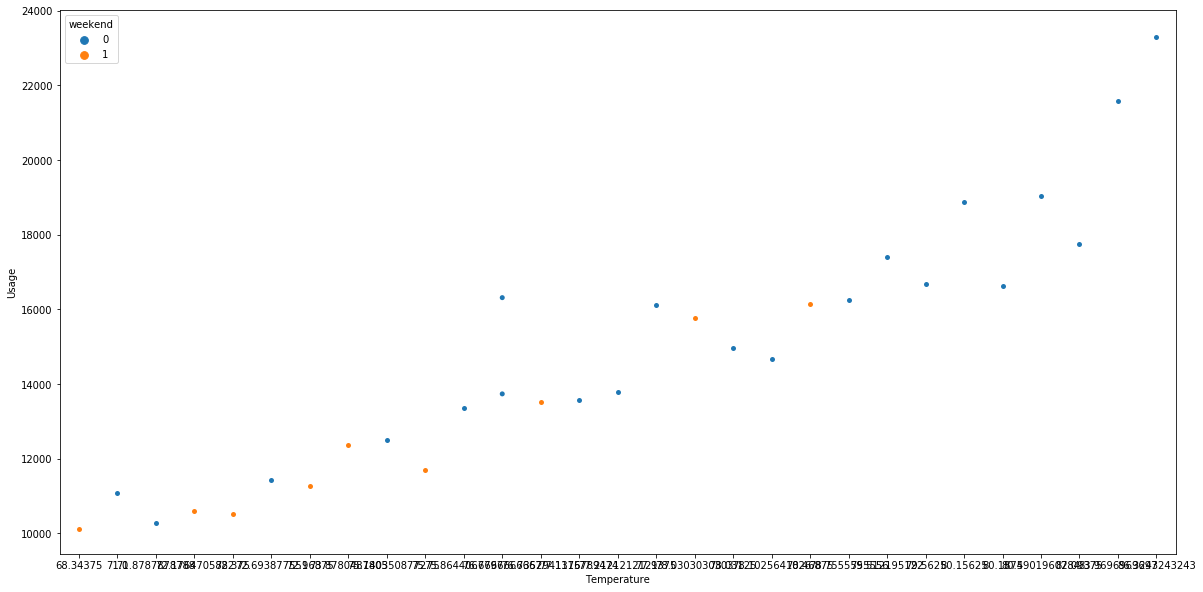

In [44]:
dfTemp = df_full[df_full['year']==2014]
dfTemp = dfTemp[dfTemp['month']==6]
sns.swarmplot(x=dfTemp['Temperature'], y=df_full['Usage'], hue=dfTemp['weekend']);

I want to see if there is any pattern between weekend and weekdays. Above plot is usage vs temperature for a month. 
Some weekends, the consumption is high and some weekends it is low. We would need customers' schedule for better correlation. 

In [45]:
#separate input and target
y = df_full['Usage']
#drop the features that might not be useful
df = df_full.drop(['year','Usage','daymonth','Temperature'],axis=1)
df.columns

Index(['month', 'dayinweek', 'Hdd', 'Cdd', 'weekend'], dtype='object')

In [46]:
def setupFeatures(df, y, splitN):  
    #test-train split
    #splitN = 24
    xtrain, xtest, ytrain, ytest = df.head(-splitN), df.tail(splitN), y.head(-splitN), y.tail(splitN)
    print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

    #fft of signal
    print("FFT")
    xsig = fftSignal(ytrain,splitN)
    xtrain['sig'] = xsig[:-splitN]
    xtest['sig'] = xsig[-splitN:]
    
    xtest = xtest.reset_index(drop=True);
    ytest = ytest.reset_index(drop=True);
    return xtrain, xtest, ytrain, ytest
    #scale prediction data
    #df_full = scaleFeatures(df_full, False)


In [47]:
#Here I want to try out adding a cosine signal with high frequencies filtered out. 
#Following FFT signal generation code copied from google.com.
def fftSignal(y, npredict):
    from numpy import fft
    n=len(y)
    print("len:",n)
    indexes = list(range(n))
    n_harm = 3              # number of harmonics in model
    x_freqdom = []   
    f = []
    t = np.arange(0, n)


    print("training fft")
    p = np.polyfit(t, y, 1)         # find linear trend in x
    x_notrend = y - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    print("Frequencies:")
    indexes.sort(key = lambda i: np.absolute(f[i]))
    print(len(x_freqdom))
    print(len(f))
    t = np.arange(0, n+npredict)
    restored_sig = np.zeros(t.size)

    for i in indexes[:1 + n_harm ]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    restored_sig = restored_sig + p[0] * t
    return restored_sig

In [48]:
print(df.shape)
split = 30 #(30 days of testing data)
xtrain, xtest, ytrain, ytest = setupFeatures(df, y, split)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)


(435, 5)
(405, 5) (30, 5) (405,) (30,)
FFT
len: 405
training fft
Frequencies:
405
405
(405, 6) (30, 6) (405,) (30,)


/home/sravan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/sravan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


I will create data pipelines and will train Linear regression, MLP Neural Nets and Gradient boosting. I will compare MAPE for each of these on test data set and plot the actual vs predicted energy usage plots. 

In [49]:
def createPipelines():
    scalCols = ['Hdd','Cdd', 'sig','diffL1Usage', 'prevWkUsage']
    #scalCols = ['Hdd','Cdd']
    encodCols = ['weekend']
    mapper = DataFrameMapper([(d, LabelEncoder()) for d in encodCols])
    funion = FeatureUnion([('categorical',Pipeline([('mapper', mapper), ('onehot', OneHotEncoder())])), 
                       ('scaler',StandardScaler(scalCols))])
    pipe_lr = Pipeline([('funion', funion),('regressor',LinearRegression())])
    pipe_mlpr = Pipeline([('funion', funion),('regressor',MLPRegressor())])
    pipe_mlpr.set_params(regressor__hidden_layer_sizes=(10),regressor__solver='lbfgs')
    pipe_gbr = Pipeline([('funion', funion),('regressor',GradientBoostingRegressor())])
    pipes = {"Linear":pipe_lr,"MLP":pipe_mlpr, "GradientBoosting":pipe_gbr}
    return pipes

In [50]:
models = {}
pipes = createPipelines()
#print(pipes)
for pipe, est in enumerate(pipes):
    print(est)
    model = pipes[est].fit(xtrain, ytrain)
    print(model)
    models[est] = model

Linear
Pipeline(memory=None,
     steps=[('funion', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('weekend', LabelEncoder())], input_df=False,
        sparse=False)), ('onehot', OneHotEncoder(categorical_fea...None)), ('regressor', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
MLP
Pipeline(memory=None,
     steps=[('funion', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical', Pipeline(memory=None,
     steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[('weekend', LabelEncoder())], input_df=False,
        sparse=False)), ('onehot', OneHotEncoder(categorical_fea...True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])
GradientBoosting
Pipeline(memory=None,
     steps=[('funion', FeatureUnion(n_jobs=1,
       transformer_list=[('categorical',

In [51]:
#Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [52]:
ypredicts = {}
def forecast(df, models):
    for model in models:
        print(model)
        ypredict = models[model].predict(df)
        mape = mean_absolute_percentage_error(ytest, ypredict)
        ypredicts[model] = ypredict
        print("MAPE for %s "%model, ":%f" %mape)
        #Test data against predicted data
        plt.figure(figsize=(10,4))
        plt.title(model)
        plt.plot(ytest, label = 'test')
        plt.plot(ypredict, label = 'predicted')
        ax =plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels)
        plt.grid('on')

Linear
MAPE for Linear  :5.618996
MLP
MAPE for MLP  :6.557275
GradientBoosting
MAPE for GradientBoosting  :6.589504


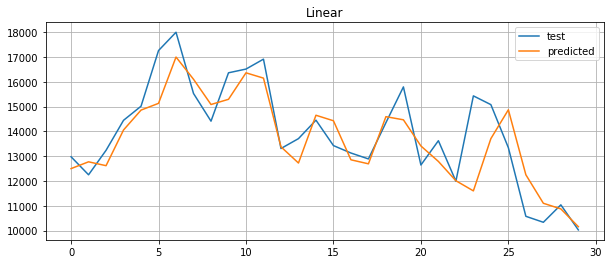

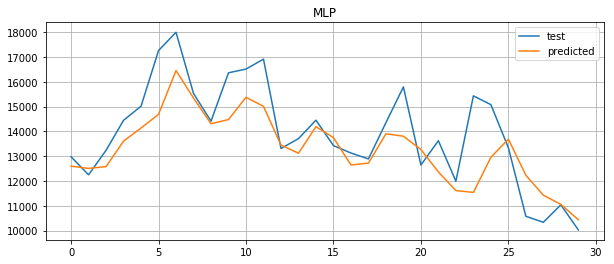

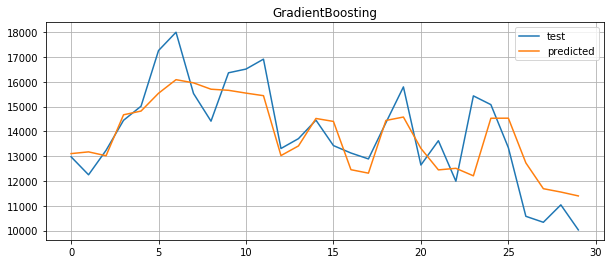

In [53]:
yForecast = forecast(xtest, models)

The predictions look decent enough. Here are couple of key observations:
    1. Data anomalies in usage patterns can be detected by comparing MAPE values.
    2. Ensemble methods performing better than simple linear regression. Lasso regression does a good job as well. Often simpler models will get the job done.
    3. With more training data, neural nets perform better.
    4. Always scale continuous values and encode categorical values. 
    If not, the distance based algorithms will quantify them based on the magnitude and may give rise to spurious regression.
    5. Consumer usage patterns over the weekends are not strongly correlated with weather. This is due to the fact that we do not have their weekend schedules. It is observed that certain weekends, the load usage is high where as for other weekends it is very low keeping all other variables constant.
    6. Not all kinds of loads correlate with weather. Take for example industrial loading will have dependency on economic parameters rather than weather. 
    7. I have explored classical models ARIMAX/SARIMAX. I feel with regression based, I have great flexibility to experiment with different input features.
    8. Harmonic filtering 3-7 gave good accuracy for hourly models. Using higher order harmonics will introduce more variance to the model. 